<a href="https://colab.research.google.com/github/kozen88/ProgettoIcon2023/blob/main/Ensemble_learning_model_WORK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble learning
L'ensemble learning risulta essere un ottimo approccio per affrontare dataset sbilanciati e cercare di apprendere al meglio il concetto che si voglia la macchina apprenda, per tali ragioni andremo ad addestrare un modello di ensemble e ottimizzarlo.

ricordiamo che le tecniche di ensemble si dividono in:
- Baggging
- Boosting
- Stacking

Ogniuna presenta caratteristiche e peculiarità di apprendimento differenti, per lo studio iniziamo scegliendo la tecnica di Bagging che sta per Boostrap Agregating l'idea è addestrare più classificatore su differenti training set creati tutti a partire dai nostri dati di partenza per mezzo di un processo di campionamento randomico con reinserimento degli esempi selezionati per un campione. Alla fine i modelli addestrati produrranno delle predizioni le quali saranno aggregate tramite una funzione di aggregazionne nella predizione finale.

Scegliamo come modello enemble basto su bagging il
- Random Forest

In [1]:
from ast import increment_lineno
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import precision_score, f1_score, fbeta_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
sns.set_style('darkgrid')

In [2]:
df_impiegati = pd.read_excel('Data_set_impiegati_one_hot_enc.xlsx')

In [3]:
df_impiegati

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department_RandD,department_accounting,department_human_resources,department_management,department_marketing,department_product_mng,department_sales,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,0,0,0,0,0,0,0,1,0,1,0
14995,0.37,0.48,2,160,3,0,1,0,0,0,0,0,0,0,0,1,0,1,0
14996,0.37,0.53,2,143,3,0,1,0,0,0,0,0,0,0,0,1,0,1,0
14997,0.11,0.96,6,280,4,0,1,0,0,0,0,0,0,0,0,1,0,1,0


In [ ]:
csv_file = 'Data_set_impiegati_one_hot_enc.csv'
df_impiegati.to_csv(csv_file, index=False)

Andiamo a preparare i dati per l'addestramento e in particolare andiamoli a separare con un hold out 70:30

In [4]:
X = df_impiegati.drop('left', axis=1)
y = df_impiegati['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train, y_test = y_train.values, y_test.values
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (11249, 18)
X_test shape:  (3750, 18)
y_train.shape:  (11249,)
y_test shape:  (3750,)


In [6]:
def stampa_metriche(pred_train, pred_test, y_train, y_test, model):
    # Calcola e stampa l'accuracy per il train set e il test set
    accuracy_train = accuracy_score(y_train, pred_train)
    accuracy_test = accuracy_score(y_test, pred_test)
    print("----------CONFRONTO PERFORMANCE TRAIN VS TEST-----------")
    print(f"Modello valutato: {model}")
    print(f'Accuracy (Train): {accuracy_train}')
    print(f'Accuracy (Test): {accuracy_test}')

    # Calcola e stampa precision, recall, e F1-score per il train set e il test set
    precision_train = precision_score(y_train, pred_train, average='macro')
    recall_train = recall_score(y_train, pred_train, average='macro')
    f1_train = f1_score(y_train, pred_train, average='macro')

    precision_test = precision_score(y_test, pred_test, average='macro')
    recall_test = recall_score(y_test, pred_test, average='macro')
    f1_test = f1_score(y_test, pred_test, average='macro')

    print(f'Precision (Train): {precision_train}')
    print(f'Precision (Test): {precision_test}')
    print(f'Recall (Train): {recall_train}')
    print(f'Recall (Test): {recall_test}')
    print(f'F1-Score (Train): {f1_train}')
    print(f'F1-Score (Test): {f1_test}')

    # Stampa classification report per il train set e il test set
    print('Classification Report (Train):\n', classification_report(y_train, pred_train))
    print('Classification Report (Test):\n', classification_report(y_test, pred_test))

Iniziamo con l'addestramento standard pèer il random forest che consiste in un addestramento tramite un hold out a 70:30 e in seguito andremo a confrontare i risultati ottenuti sul training con quelli del test per verificare che non ci siano anomalie nell'addestramento e ch non si sia verificato overfitting. Una volta terminato l'addestramento base andremo a convalidare i risultati ottenuti con un convalida incrociata.

In [7]:
# Instanziamo un modello Random forest e andiamo ad addestrarlo con hold out
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

pred_rf_train = rf.predict(X_train)
pred_rf = rf.predict(X_test)

In [8]:
# Utilizzo della funzione per mostrare le predizioni a confronto tra train e test
stampa_metriche(pred_rf_train, pred_rf, y_train, y_test, "RANDOM FOREST")

----------CONFRONTO PERFORMANCE TRAIN VS TEST-----------
Modello valutato: RANDOM FOREST
Accuracy (Train): 1.0
Accuracy (Test): 0.9890666666666666
Precision (Train): 1.0
Precision (Test): 0.9900742337164752
Recall (Train): 1.0
Recall (Test): 0.9798211587403742
F1-Score (Train): 1.0
F1-Score (Test): 0.984822626103247
Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8575
           1       1.00      1.00      1.00      2674

    accuracy                           1.00     11249
   macro avg       1.00      1.00      1.00     11249
weighted avg       1.00      1.00      1.00     11249

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2853
           1       0.99      0.96      0.98       897

    accuracy                           0.99      3750
   macro avg       0.99      0.98      0.98      3750
weighted avg       0

Questa volta il modello di ensemble sul test ha meno performance rispetto al train e questo sembra nella norma, ma credere che sul train ottenga il 100% senza commettere errore è difficile da credere!!!

In [9]:
print("_______________RANDOM FOREST PERFORMANCE________________")
print("------------------------Accuracy------------------------")
print()
print(accuracy_score(y_test, pred_rf))
print()
print("------------------Classification_Report-----------------")
print()
print(classification_report(y_test, pred_rf))

_______________RANDOM FOREST PERFORMANCE________________
------------------------Accuracy------------------------

0.9890666666666666

------------------Classification_Report-----------------

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2853
           1       0.99      0.96      0.98       897

    accuracy                           0.99      3750
   macro avg       0.99      0.98      0.98      3750
weighted avg       0.99      0.99      0.99      3750



In [10]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', fontsize=22, title_color='#660000'):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Calcola le percentuali
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap='OrRd')  # Utilizza fmt=".2%" per visualizzare le percentuali con due decimali
    plt.title(title, fontsize=fontsize, color=title_color)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

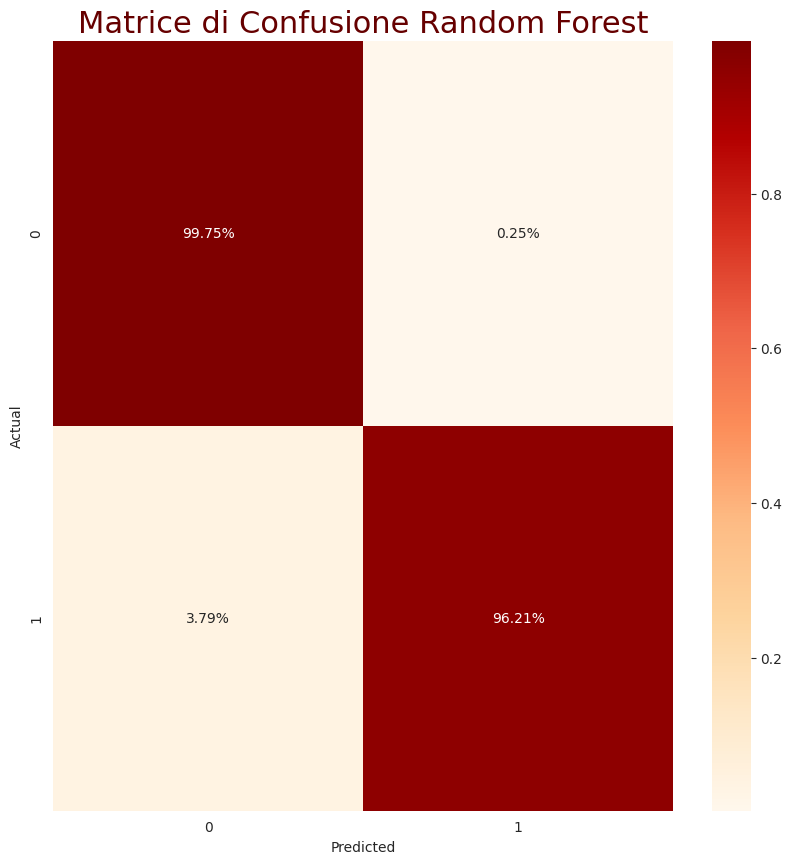

In [11]:
plot_confusion_matrix(y_test, pred_rf, title='Matrice di Confusione Random Forest', fontsize=22, title_color='#660000')

Effettuiamo dei rrun con differenti fold per cross validation per capire se le performance ottenute sono un caso o sono stabili

In [12]:
random_forest_cv_score = cross_val_score(RandomForestClassifier(), X, y, cv=8, scoring='recall')
print("Random Forest Cross Validation Recall scores are: {}".format(random_forest_cv_score ))
print("Random Forest Average Cross Validation Recall score: {}".format(random_forest_cv_score.mean()))

Random Forest Cross Validation Recall scores are: [1.         0.97986577 0.93064877 0.89910314 0.98206278 1.
 1.         1.        ]
Random Forest Average Cross Validation Recall score: 0.973960057583692


## Fine addestramento di base Random Forest
Dopo aver addestrato un modello di ensemble learning i risultati sono stati ottimi a fronte di un addestramento base senza ottimizzazione degli iperparametri nè di un processo di cross validation stratificata infatti il solo hold out è stato sufficiente a superare di gran lunga i risultati ottenuti con i Gaussian Naive Bayes e con la Logist Regression. Nonostatne gli ottimi risultati sorge il sospetto che il dataset non sia contenetne dati provenienti da un ambiente di lavoro reale dato che riuscire ad avere i risultati che abbiamo ottenuto sembra alquanto irrealistico dato che sono ottimi.

## Continuiamo la sperimentazione sui modelli di ensemble
Adesso andremo ad addestrare un modello di ensemble basato su stacking. Questa tecnica è molto differente dalla precedente primo perchè utilizza più learner di base da cui andrà ad estrarre la predizione finale. L'idea alla base è quella di andare ad addestrare indipendentemente un numero di classificatori di base alla fine del loro addestramento le loro predizioni saranno combinate tramite una funzione aggregate tale funzione aggregante sarà appresa dal meta-learner un modello finale atta a combinare le predizioni dei modelli di base per fornire la predizione finale.

Per la sperimentazione del modello di stacking si sceelgono come classificatori di base indipendenti un albero di decisione , un naive bayes e una support vector machine i quali saranno aggregati da un meta learner basato su classificatore di regressione logistica.

Iniziamo addestrando  lo stacking model con il classico hold out 70:30 e andremo in seguito a valutare i risultati ottenuti sia sul train che sul test per controllare anomalie verificatesi durante l'addestramento quali in particolare fenomeni di overfitting e in fine eseguire una convalidda incrociata pèer validare i risultati ottenuti con hold out.

In [13]:
# Definisci i classificatori base che fornirranno la pila di modelli
base_classifiers = [
    ('decTree', DecisionTreeClassifier()),
    ('gaussiaNB', GaussianNB()),
    ('svm', SVC())
]

# Andiamo a creare il modello di stacking a partire da quelli di base e dal meta-learner
# che sarà il final_classifier
final_classifier = LogisticRegression()
stacking_classifier = StackingClassifier(estimators=base_classifiers, final_estimator=final_classifier)

# Addestra il classificatore di stacking e raccolta delle predizioni di train e di test per successive valutazioni
stacking_classifier.fit(X_train, y_train)
pred_stacking_train = stacking_classifier.predict(X_train)
pred_stacking = stacking_classifier.predict(X_test)

In [14]:
# Utilizzo della funzione per mostrare le predizioni a confronto tra train e test
stampa_metriche(pred_stacking_train, pred_stacking, y_train, y_test, "STACKING MODEL")

----------CONFRONTO PERFORMANCE TRAIN VS TEST-----------
Modello valutato: STACKING MODEL
Accuracy (Train): 1.0
Accuracy (Test): 0.9717333333333333
Precision (Train): 1.0
Precision (Test): 0.9557384141072747
Recall (Train): 1.0
Recall (Test): 0.9680474815572881
F1-Score (Train): 1.0
F1-Score (Test): 0.9616908086853442
Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8575
           1       1.00      1.00      1.00      2674

    accuracy                           1.00     11249
   macro avg       1.00      1.00      1.00     11249
weighted avg       1.00      1.00      1.00     11249

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      2853
           1       0.92      0.96      0.94       897

    accuracy                           0.97      3750
   macro avg       0.96      0.97      0.96      3750
weighted avg      

Anche per lo stacking model comparando i risultati sul training e sul test possiamo dire che non si riscontrano anomalie nel senso che come ci aspettiamo normalmente un modello si comporterà peggio sul test rispetto al train e di fatto le percentuali sulle metriche si riducono tutte, per tali ragioni  escludiamo anche fenomeni di overfitting dato che le performance si mantengono alte sia sul train che sul test. Rimane però alquanto strano che il modello non  commetta errrori sul training.

In [15]:
print("_______________STACKING MODEL PERFORMANCE________________")
print("------------------------Accuracy------------------------")
print()
print(accuracy_score(y_test, pred_stacking))
print()
print("------------------Classification_Report-----------------")
print()
print(classification_report(y_test, pred_stacking))

_______________STACKING MODEL PERFORMANCE________________
------------------------Accuracy------------------------

0.9717333333333333

------------------Classification_Report-----------------

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      2853
           1       0.92      0.96      0.94       897

    accuracy                           0.97      3750
   macro avg       0.96      0.97      0.96      3750
weighted avg       0.97      0.97      0.97      3750



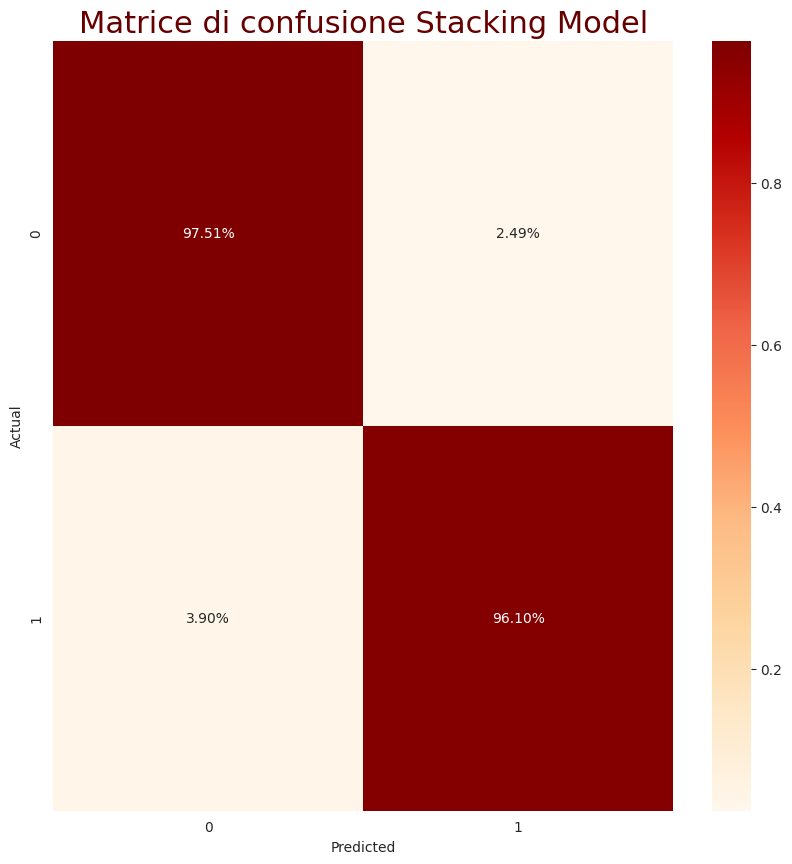

In [16]:
plot_confusion_matrix(y_test, pred_stacking, title='Matrice di confusione Stacking Model', fontsize=22, title_color='#660000')

Andiamo a eseguire un paio di run con valori differenti di fold per la cross validation per capire se i risultati ottenuti precedentemente sono unn caso oppure il modello si comporta con tali porestazioni alte.

In [17]:
stacking__cv_score = cross_val_score(StackingClassifier(estimators=base_classifiers, final_estimator=final_classifier), X, y, cv=5, scoring='recall')
print("Stacking Cross Validation Recall scores are: {}".format(stacking__cv_score))
print("Stacking Average Cross Validation Recall score: {}".format(stacking__cv_score.mean()))

Stacking Cross Validation Recall scores are: [1.         0.91876751 0.94537815 1.         1.        ]
Stacking Average Cross Validation Recall score: 0.9728291316526609


Abbiamo terminato l'addestramento base di un modello di ensemble basato su stacking, anche questo ha portato a risultati di enorme differenza anche se non è risultato quasi perfetto come lo è stato il Random Forest.

## Ensemble model basati su Boosting
L'idea dietro un modello di Boosting è utilizzare un classificatore di base che prende il nome di weak learner e addestrarlo indipendetemente sul train set una volta addestrato si utilizzeranno le sue predizioni per stabilire una funzione dei pesi che sarà applicata ad un successivo classificatore che sarà lo stesso modello di quello base, ma il quale dovrà andare a migliorare i risultati ottenuti dal precedente attraverso l'applicazione di pesi sulle predizioni che andrà a sbalgiare. Il cooncetto dietro questa tecnica è che i modelli base andranno a migliorarsi sequenzialmente uno dopo l'altro andando ad apprendere dagli sbagli commessi dai loro predecessori.

Per questa classe di modelli appartenenti alle tecniche di Boosting scegliamo di addestrare come modello:

- ADABoost

Iniziamo l'addestrramento del ADABoost, per cominciare addestreremo il modello con il classico split di hold out 70:30 e andremo a valutare i risultati ottenuti prima di confalidarli con una cross validation.

In [18]:
# Definisci il classificatore base (un DecisionTreeClassifier) che servirà all' ADABoost come weak learner da migliorare
base_classifier = DecisionTreeClassifier(max_depth=5)
adaboost_classifier = AdaBoostClassifier(estimator=base_classifier, n_estimators=50, random_state=42)

# Addestra il classificatore AdaBoost e raccogliamo le predizioni sul train e sul test
adaboost_classifier.fit(X_train, y_train)
pred_adaboost_train = adaboost_classifier.predict(X_train)
pred_adaboost = adaboost_classifier.predict(X_test)

In [19]:
# Utilizzo della funzione per mostrare le predizioni a confronto tra train e test
stampa_metriche(pred_adaboost_train, pred_adaboost, y_train, y_test, "ADABOOST")

----------CONFRONTO PERFORMANCE TRAIN VS TEST-----------
Modello valutato: ADABOOST
Accuracy (Train): 1.0
Accuracy (Test): 0.9853333333333333
Precision (Train): 1.0
Precision (Test): 0.9810972735130039
Recall (Train): 1.0
Recall (Test): 0.9785140795290295
F1-Score (Train): 1.0
F1-Score (Test): 0.9797974969661963
Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8575
           1       1.00      1.00      1.00      2674

    accuracy                           1.00     11249
   macro avg       1.00      1.00      1.00     11249
weighted avg       1.00      1.00      1.00     11249

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      2853
           1       0.97      0.97      0.97       897

    accuracy                           0.99      3750
   macro avg       0.98      0.98      0.98      3750
weighted avg       0.99 

Anche per questo ultmio modello di ensemble tiriamo le stesse conclusioni fattte per i precedenti. Escludiasmo fenomeni di overrfitting dato il confronto tra train e test, ma resta sospetto e irrealistico il 100% sul test.

In [20]:
print("__________________ADABOOST PERFORMANCE__________________")
print("------------------------Accuracy------------------------")
print()
print(accuracy_score(y_test, pred_adaboost))
print()
print("------------------Classification_Report-----------------")
print()
print(classification_report(y_test, pred_adaboost))

__________________ADABOOST PERFORMANCE__________________
------------------------Accuracy------------------------

0.9853333333333333

------------------Classification_Report-----------------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2853
           1       0.97      0.97      0.97       897

    accuracy                           0.99      3750
   macro avg       0.98      0.98      0.98      3750
weighted avg       0.99      0.99      0.99      3750



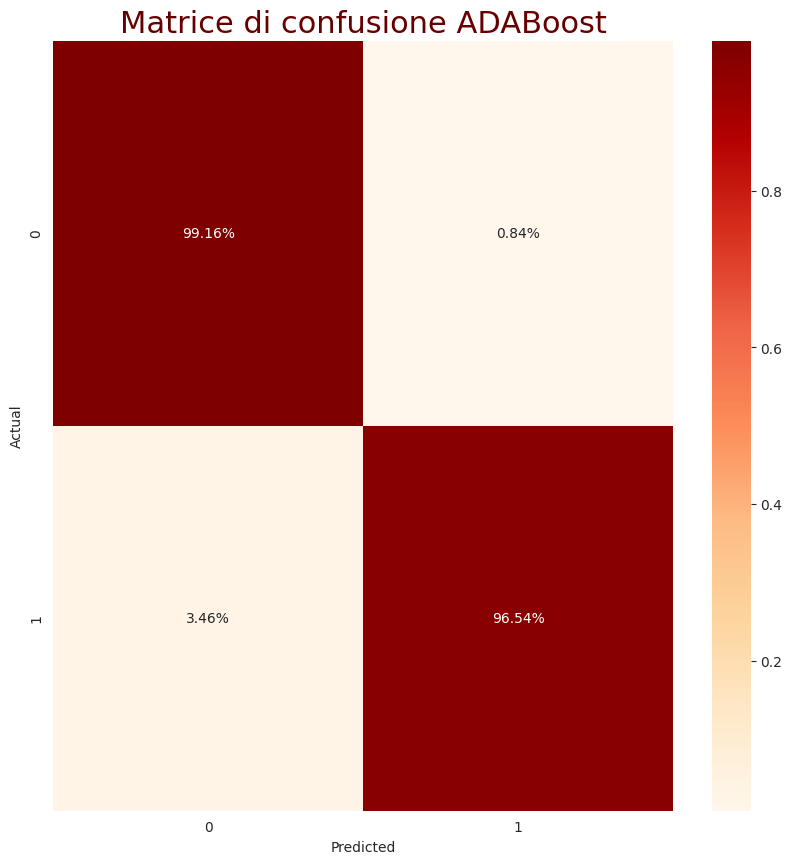

In [21]:
plot_confusion_matrix(y_test, pred_adaboost, title='Matrice di confusione ADABoost', fontsize=22, title_color='#660000')

Effettuiamo un paio di tentativi con la cross validation per verificare le performance del modello

In [22]:
adaboost__cv_score = cross_val_score(AdaBoostClassifier(), X, y, cv=5, scoring='recall')
print("AdaBoost Cross Validation Recall scores are: {}".format(adaboost__cv_score))
print("AdaBoost Average Cross Validation Recall score: {}".format(adaboost__cv_score.mean()))

AdaBoost Cross Validation Recall scores are: [0.91748252 0.90896359 0.89495798 0.91316527 0.91176471]
AdaBoost Average Cross Validation Recall score: 0.9092668116197528


si nota come per l'adaboost utilizzando il processo di convalida incrociata abbassi notevolmente le sue performance scendendo addirittura ad una media del 90% circa contro il 96% di partezza ottenuto sul hold-out.

L'ultimo modello di ensemble l'ADAboost sembra eccellere nell'addestramento proprio come ha fatto il Random forest.

## CONFRONTO FINALE TRA I MODELLI DI ENSEMBLE PER DICHIARARE IL MIGLIORE
Andremo a mettere a confronto i classificatori addestrati utilizzando il punteggio ROC e AUROC e visualizzeremo tale confronto su di un grafico adeguato per coglierne le differenze e decretare il miglior modello.

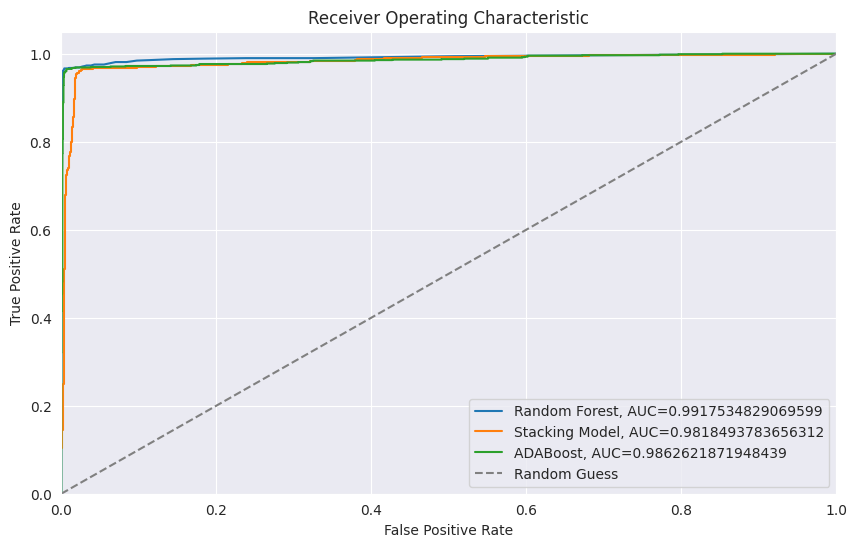

In [23]:
# Calcola i punteggi delle probabilità positive
pred_RF_positive = rf.predict_proba(X_test)[:, 1]
pred_SM_positive = stacking_classifier.predict_proba(X_test)[:, 1]
pred_AB_positive = adaboost_classifier.predict_proba(X_test)[:, 1]

# Calcola le curve ROC e gli AUC
fpr_RF, tpr_RF, _ = roc_curve(y_test, pred_RF_positive)
auc_RF = roc_auc_score(y_test, pred_RF_positive)

fpr_SM, tpr_SM, _ = roc_curve(y_test, pred_SM_positive)
auc_SM = roc_auc_score(y_test, pred_SM_positive)

fpr_AB, tpr_AB, _ = roc_curve(y_test, pred_AB_positive)
auc_AB = roc_auc_score(y_test, pred_AB_positive)

# Crea il grafico ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_RF, tpr_RF, label="Random Forest, AUC=" + str(auc_RF))
plt.plot(fpr_SM, tpr_SM, label="Stacking Model, AUC=" + str(auc_SM))
plt.plot(fpr_AB, tpr_AB, label="ADABoost, AUC=" + str(auc_AB))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


- CONCLUSIONI: il modello più performante tra i modelli di ensemble utilizzati è risultato essere il random forest, ad ogni modo si può ben dire che tutti i modelli addestrati in questo notebook hanno ottenuto risultati eccellenti anzi anche troppo eccellenti per essere considerati veritieri per tali ragioni si sospetta qualche problema con il dataset. Infine per il task posto dall'inizio e a fronte delle metriche di valutazione utlizzate il random forest è il modello più idone a gestire il problema dei dipendenti che lascieranno l'azienda.

## Sperimentazione sugli ensemble model
Cercheremo di capire come le performance di questi modelli varino in base al numero di fold utilizzato per effettuare la convalida incrociata dei dati per l'addestramento, questo ci servirà a capire quale k sia il migliore da utilizzare per ottimizzare i modelli in seguito.

In [24]:
# la funzione eseguirà l'addestramento del modello usato una cross validartion stratificata
# e andra a plottare un grafico che mostrerà i risultati dell'addestramento in base ad una
# metrica che si vuole massimizzare
# occhio questa funzione necessita di array numpy e non di data frame!!!!!!!
def kfold_crossval_plot(X, y, model, metric_function, metric_name, k_range):

    metric_scores = []
    num_folds_used = []

    for k in k_range:
        kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        fold_metrics = []

        for train_index, val_index in kf.split(X, y):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            metric = metric_function(y_val, y_pred)

            fold_metrics.append(metric)

        avg_metric = np.mean(fold_metrics)
        metric_scores.append(avg_metric)
        num_folds_used.append(k)

    plt.figure(figsize=(10, 6))
    plt.plot(num_folds_used, metric_scores, marker='o')
    plt.xlabel("Numero di Folds (k)")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} in Base al Numero di Folds (k)")
    plt.grid(True)
    plt.show()

- Random forest ricerca del miglior fold

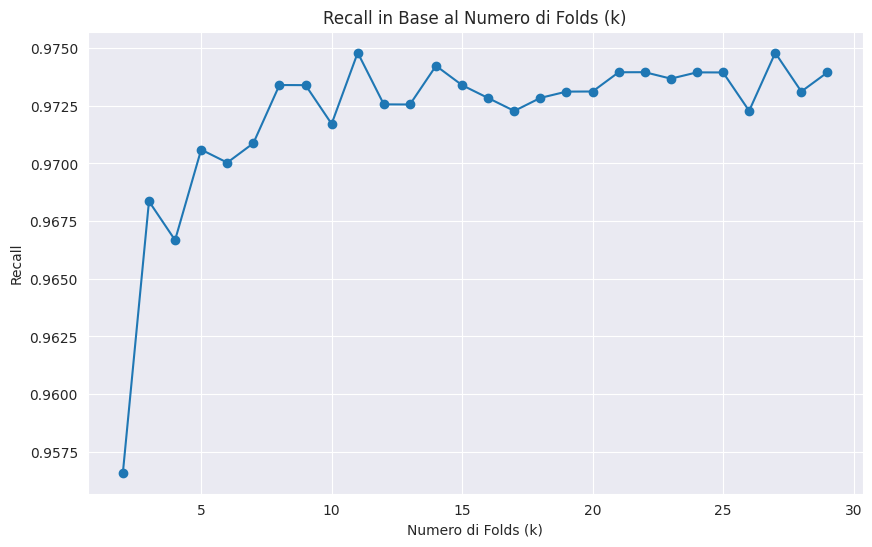

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
X_array = X.values
y_array = y.values
kfold_crossval_plot(X_array, y_array, random_forest, recall_score, "Recall", range(2,30))

In [ ]:
X_array = X.values
y_array = y.values

- Stacking model ricerca del miglior fold

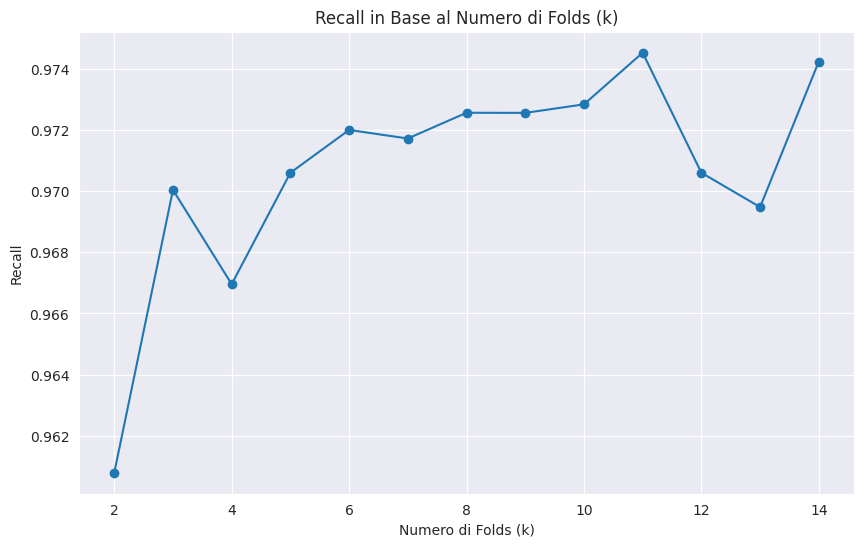

In [ ]:
#Andiamo a valutare il modello di stacking sul numero del CV in modo incrementale

base_classifiers_1 = [
    ('decTree', DecisionTreeClassifier()),
    ('gaussiaNB', GaussianNB()),
    ('svm', SVC())
]
final_classifier_1 = LogisticRegression()
stacking_classifier_1 = StackingClassifier(estimators=base_classifiers_1 , final_estimator=final_classifier_1)

kfold_crossval_plot(X_array, y_array, stacking_classifier_1, recall_score, "Recall", range(2,15))


- AdaBoost ricerca del miglior fold

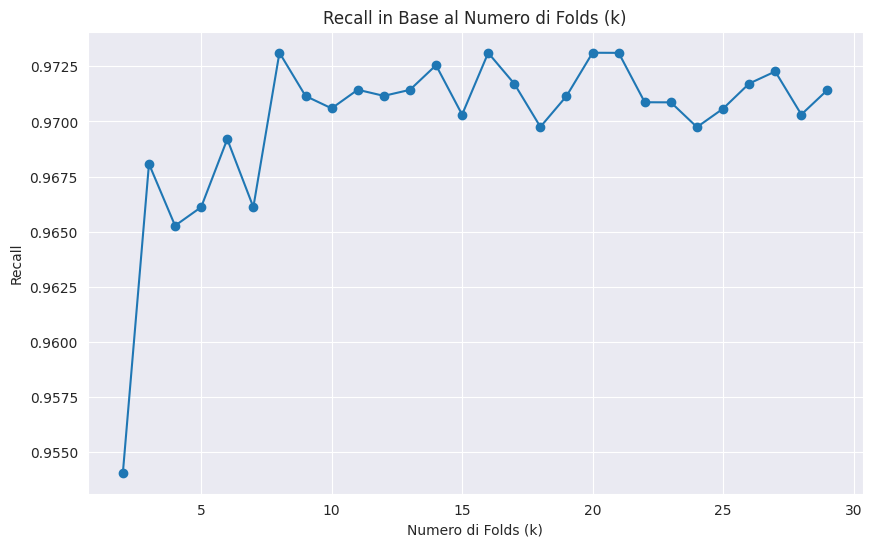

In [ ]:
adaboost_c = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=50, random_state=42)
kfold_crossval_plot(X_array, y_array, adaboost_c, recall_score, "Recall", range(2,30))

## OTTIMIZZAZIONE DEI PARAMETRI DEI MODELLI
Proviamo ad ottimizzare i modelli precedentemente addestrati e effettuare una cross validation dei modelli finali ottimizzati con il migliore fold per gli split della cross validation

Ottimizzazione dell'AdaBoost

In [38]:
parametri_adaboost = {
    'n_estimators': [25, 50, 75, 100],           # Numero di stimatori (alberi)
    'learning_rate': [0.01, 0.1, 0.5, 1.0],       # Tasso di apprendimento
    'algorithm': ['SAMME', 'SAMME.R'],           # Algoritmo utilizzato
    'random_state': [30]
}

In [29]:
# Crea un oggetto GridSearchCV
grid_search_adaboost = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=parametri_adaboost, cv=8, scoring='recall')

# Addestra il modello
grid_search_adaboost.fit(X_train, y_train)

# Ottieni i parametri migliori
best_params_adaboost = grid_search_adaboost.best_params_
best_score_adaboost_grids = grid_search_adaboost.best_score_
print('Best parameters:',best_params_adaboost)
print('Best score:', best_score_adaboost_grids)

Best parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 75, 'random_state': 30}
Best score: 0.9083877022075253


Effettuaiamo il run per la cross validatrion con il modello finale dato dai migliori parametri ottenuti con la grid search

In [44]:
# Andiamo ad effettuare la cross validation del modello con parametri ottimizzati andando ad utilizzare il miglior k fold per la convalida incrociata
# calcolato con i precedenti esperimenti
adaboost_best_param_cv_score = cross_val_score(AdaBoostClassifier(**best_params_adaboost), X, y, cv=8, scoring='recall')
print("AdaBoost Best param Cross Validation Recall scores are: {}".format(adaboost_best_param_cv_score ))
print("AdaBoost Best param Average Cross Validation Recall score: {}".format(adaboost_best_param_cv_score.mean()))

AdaBoost Best param Cross Validation Recall scores are: [0.93512304 0.8836689  0.92393736 0.88340807 0.91928251 0.91704036
 0.92376682 0.91255605]
AdaBoost Best param Average Cross Validation Recall score: 0.912347889768361


Ottimizzazione del Random Forest

In [40]:
parametri_random_forest = {
    'n_estimators': [25, 50, 75, 100],            # Numero di alberi nella foresta
    'criterion': ['gini', 'entropy'],         # Criterio di suddivisione
    'max_depth': [None, 3, 5, 8, 12, 15],           # Profondità massima degli alberi
    'min_samples_split': [2, 5, 10],         # Numero minimo di campioni per dividere un nodo interno
    'min_samples_leaf': [1, 2, 4],           # Numero minimo di campioni in una foglia
    'max_features': ['log2', 'sqrt'],        # Numero massimo di feature da considerare per il miglior split
    'bootstrap': [True, False]               # Se campioni di addestramento vengono sostituiti
}

In [41]:
# Crea un oggetto GridSearchCV
grid_search_random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametri_random_forest, cv=8, scoring='recall')

# Addestra il modello
grid_search_random_forest.fit(X_train, y_train)

# Ottieni i parametri migliori
best_params_random_forest = grid_search_random_forest.best_params_
best_score_random_forest_grids = grid_search_random_forest.best_score_
print('Best parameters:',best_params_random_forest)
print('Best score:', best_score_random_forest_grids)

Best parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.9648505228349272


il precedente codice ha impiegato 2h e 30 min all'incirca

Controlliamo la validità dei risultati ottenuti effettuando dei run con diversi valori di cross validation per la verifica dei risultati ottenuti.

In [43]:
# il migliore fold da usare sarebbe 21 dall'analisi fatta comparando sia recall che precision, ma si teme che con 21 il tempo diù
# computazione sia elevato per tali ragioni si prova con 8 sperando che sia fattibile la computazione
random_forest_param_cv_score = cross_val_score(RandomForestClassifier(**best_params_random_forest), X, y, cv=21, scoring='recall')
print("Random Forest Best param Cross Validation Recall scores are: {}".format(random_forest_param_cv_score))
print("Random Forest Best param Average Cross Validation Recall score: {}".format(random_forest_param_cv_score.mean()))

Random Forest Best param Cross Validation Recall scores are: [1.         1.         1.         1.         0.95882353 0.94705882
 0.91764706 0.92352941 0.91764706 0.88823529 0.92352941 0.98823529
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]
Random Forest Best param Average Cross Validation Recall score: 0.9745098039215686


Il modello di stacking non è stato ottimizzato per due motivi non era il migliore e l'ottimizzazione avvrebbe necessitato di troppo tempo senza la distribuzione del carico computazione in parallello o comunque con hardware più performante, questo perché si necessita prima di ottimizzare i singoli basal learner quindi per ogni uno trovare la combinazione ottimale degli ipèerparametri, fin qui la questione non si complica troppo, ma una volta fatto ciò bisogna ottimizzare il meta learner sulle ottimizzazioni dei modelli base e questo rischia di essere estremamente dispendioso.